# Olist E-commerce: RFM Customer Segmentation Analysis

**Author:** Zeeshan Akram <br>
**Date:** 17 November 2025 <br>
**Project:** Olist E-commerce Performance & Profitability Analysis

---

## 1. Objective

This notebook is a separate, dedicated analysis to segment customers based on their value. The `02_Analysis` notebook focused on *item-level* and *order-level* insights (like logistics). This notebook focuses on the **customer-level**.

The goal is to perform an **RFM (Recency, Frequency, Monetary)** analysis to identify different customer cohorts. This will allow the business to move from a "one-size-fits-all" approach to a targeted, strategic marketing plan.

## 2. Why RFM Analysis Matters

RFM analysis is a classic marketing model that groups customers based on their transaction history. It's powerful because it's based on the simple premise that **80% of your business comes from 20% of your customers**. This analysis helps us find that 20%.

Instead of treating all customers equally, we can segment them and ask critical business questions:
* Who are our "Best Customers" that we must retain at all costs?
* Who are our "At-Risk" customers who are about to leave?
* Who are our "Lost Customers" that we can try to win back?
* Who are our "New Customers" that need to be nurtured?

## 3. Defining the RFM Metrics

RFM stands for:

* **Recency (R):** *How recently did the customer purchase?* A customer who bought 10 days ago is more likely to buy again than one who bought 10 months ago. (Lower recency = higher score).
* **Frequency (F):** *How often do they purchase?* A customer who has made 5 purchases is more valuable than a customer who has made 1. (Higher frequency = higher score).
* **Monetary (M):** *How much have they spent?* A customer who has spent `$1,000` is more valuable than one who has spent `$10`. (Higher monetary = higher score).

## 4. Methodology: The "Snapshot Date"

To calculate "Recency," I must establish a single "snapshot date" to represent "today." All recency calculations will be the difference between this snapshot date and the customer's last purchase date.

* **Logic:** The most robust method is to set the snapshot date as **one day *after* the most recent purchase** in the entire dataset.
* **Formula:** `Snapshot Date = max(order_purchase_timestamp) + 1 day`
* **Justification:** This ensures that even the most recent customer has a Recency of at least 1 day and that all calculations are consistent.

## Importing Libraries

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

## Loading Data

In [2]:
df = pd.read_csv('../outputs/2nd_cleaned_data.csv')
# preview
df.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,product_id,seller_id,...,seller_state,processing_time,approval_time,shipping_time,delivery_delta,freight_ratio,purchase_month,purchase_hour,purchase_day_of_week,delivery_status
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,...,SP,2.0,0.0,6.0,7.0,0.290764,October,10 AM,0,Delivered On Time
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962,...,SP,0.0,1.0,12.0,5.0,0.191744,July,08 PM,1,Delivered On Time
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,aa4383b373c6aca5d8797843e5594415,4869f7a5dfa277a7dca6462dcf3b52b2,...,SP,0.0,0.0,9.0,17.0,0.120200,August,08 AM,2,Delivered On Time
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,d0b61bfb1de832b15ba9d266ca96e5b0,66922902710d126a0e7d26b0e3805106,...,MG,3.0,0.0,9.0,12.0,0.604444,November,07 PM,5,Delivered On Time
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,65266b2da20d04dbe00c5c2d3bb7859e,2c9e548be18521d1c43cde1c582c6de8,...,SP,0.0,0.0,1.0,9.0,0.438191,February,09 PM,1,Delivered On Time


## Data Preparation for RFM

To perform the RFM analysis, I must convert my **item-level** `master_df` (113,425 rows) to a **customer-level** table (one row per `customer_unique_id`).

A simple `groupby` on the master table would result in a massively inflated **Monetary** value, as `total_payment_value` is duplicated for each item in an order.

The correct, professional workflow is a two-step aggregation:

1.  **Item-Level -> Order-Level:** Create a de-duplicated `order_df` to get one row per `order_id`.
2.  **Order-Level -> Customer-Level:** Aggregate the `order_df` by `customer_unique_id` to calculate the R, F, and M metrics.

### Create the Order-Level Table

I will select only the columns needed for RFM analysis and drop duplicates on `order_id` to create my `order_df`.

In [3]:
# Selecting only the columns needed for new `order_df`
order_level_df = df[['order_id', 'customer_unique_id', 'order_purchase_timestamp', 'total_payment_value']].copy()

# Drop duplicates to get one row per order
order_level_df.drop_duplicates(subset='order_id', inplace=True)

print(f"Original master_df shape: {df.shape}")
print(f"New order_level_df shape: {order_level_df.shape}")

Original master_df shape: (113375, 37)
New order_level_df shape: (99418, 4)


In [4]:
# converting to datetime 
order_level_df['order_purchase_timestamp'] = pd.to_datetime(order_level_df['order_purchase_timestamp'], errors='coerce')

### Step 2: Create the Customer-Level (RFM) Table

Now I will aggregate my new `order_level_df` by `customer_unique_id` to calculate the three RFM metrics.

First, I must establish the `snapshot_date`.

In [5]:
# Setting snapshot as 1 day after the latest purchase
snapshot_date = order_level_df['order_purchase_timestamp'].max() + np.timedelta64(1, 'D')
print(f"Snapshot Date: {snapshot_date}")

# Calculate RFM Metrics
rfm_df = order_level_df.groupby('customer_unique_id').agg(
    Recency=('order_purchase_timestamp', lambda x: (snapshot_date - x.max()).days),
    Frequency=('order_id', 'count'),
    Monetary=('total_payment_value', 'sum')
).reset_index()

# Inspect the new RFM table
print(f"New rfm_df shape: {rfm_df.shape}")
print(rfm_df.head())

Snapshot Date: 2018-10-18 17:30:18
New rfm_df shape: (96076, 4)
                 customer_unique_id  Recency  Frequency  Monetary
0  0000366f3b9a7992bf8c76cfdf3221e2      161          1    141.90
1  0000b849f77a49e4a4ce2b2a4ca5be3f      164          1     27.19
2  0000f46a3911fa3c0805444483337064      586          1     86.22
3  0000f6ccb0745a6a4b88665a16c9f078      370          1     43.62
4  0004aac84e0df4da2b147fca70cf8255      337          1    196.89


In [6]:
rfm_df.describe()

,Recency,Frequency,Monetary
count,96076.000000,96076.000000,96076.000000
mean,288.684167,1.034785,166.577988
std,153.380034,0.214338,231.444602
min,1.000000,1.000000,0.000000
25%,164.000000,1.000000,63.120000
50%,269.000000,1.000000,108.000000
75%,398.000000,1.000000,183.512500
max,773.000000,17.000000,13664.080000


## RFM Table Validation & Distribution Check

Before scoring, I am validating the `rfm_df` to ensure its integrity and understand the distributions of the R, F, and M metrics.

### Monetary (M) Definition

My `Monetary` value is defined as the **sum of `total_payment_value`** for all of a customer's orders. This was chosen because:
1.  My data was aggregated to the `order-level` *before* the customer-level, ensuring I am summing *unique orders* and not double-counting items.
2.  `total_payment_value` represents the *total revenue* collected from the customer, which is the true measure of their financial value to the business.

### Descriptive Statistics

* **Recency:** Ranges from **1 day (min)** to **773 days (max)**. The **median** is **269 days**, with a **mean** of **288.68 days**, suggesting a relatively even spread of customer activity over two years.
* **Frequency:** Ranges from **1 (min)** to **17 (max)**. The **median** is **1**, and the **mean** is **1.03**. This confirms that the vast majority of the **96,076 customers** in the dataset have made only **one purchase**.
* **Monetary:** Ranges from **R\$0.00 (min)** to a max of **R\$13,664.08**. The **mean** is **R\$166.58**, but the **median** is only **R\$108.00**. This large difference confirms a **strong right-skew** in the data, driven by a few high-value customers.

## Handling 0.00 Monetary Values

My statistical check revealed a `min` value of 0.00 for `Monetary`.

* **Analysis:** These are not real customers. They are data artifacts representing orders that had no valid, non-zero payment transaction (e.g., `not_defined` payments or orders with no items).
* **Justification:** An RFM analysis is for segmenting *paying* customers. These 0-value accounts cannot be scored and will skew the segmentation.
* **Action:** I am **dropping all rows** from the `rfm_df` where `Monetary == 0`. This cleans the dataset, ensuring I am only segmenting valid, revenue-generating customers.

In [7]:
rfm_df = rfm_df[~(rfm_df['Monetary'] == 0)]

## Visualizing RFM Metric Distributions

Before I can create R, F, and M scores, I must understand the distribution of each metric. This is critical for choosing a fair scoring method (like quantiles) that correctly handles the data's extreme skew.

* **Recency:** A histogram will visualize the spread of customer activity, from recently active to long-dormant.
* **Frequency:** A **bar chart** is the best tool here. It will visually confirm the most critical insight from my validation: the business is overwhelmingly composed of **one-time buyers (F=1)**.
* **Monetary:** A boxplot and a log-scaled histogram will visualize the extreme right-skew. This will confirm the "80/20 rule," showing that a small number of "whale" customers are responsible for a disproportionately high amount of total revenue.

## Recency Distribution

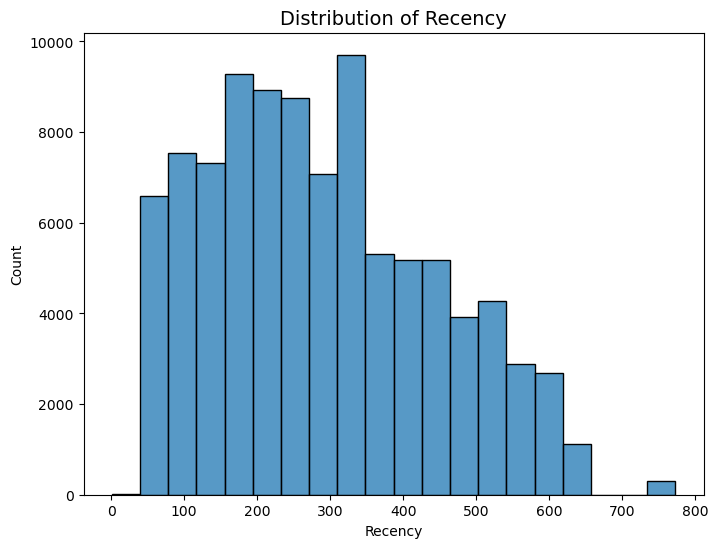

In [8]:
plt.figure(figsize=(8,6))
sns.histplot(data=rfm_df, x='Recency', bins=20)
plt.title("Distribution of Recency", fontsize=14)
plt.show()

## Visualizing RFM Metric Distributions

### Recency (R)

The histogram for Recency shows the activity status of the customer base.

* **Key Insight:** The distribution is heavily weighted towards high recency values, with a large "bulge" of customers in the 100-400 day range.
* **Business Impact:** This is a clear visualization of a **customer retention problem**. There is no significant peak of recent (low-recency) customers. This proves that the vast majority of our customer base is "dormant," and the business is not successfully re-engaging past buyers.

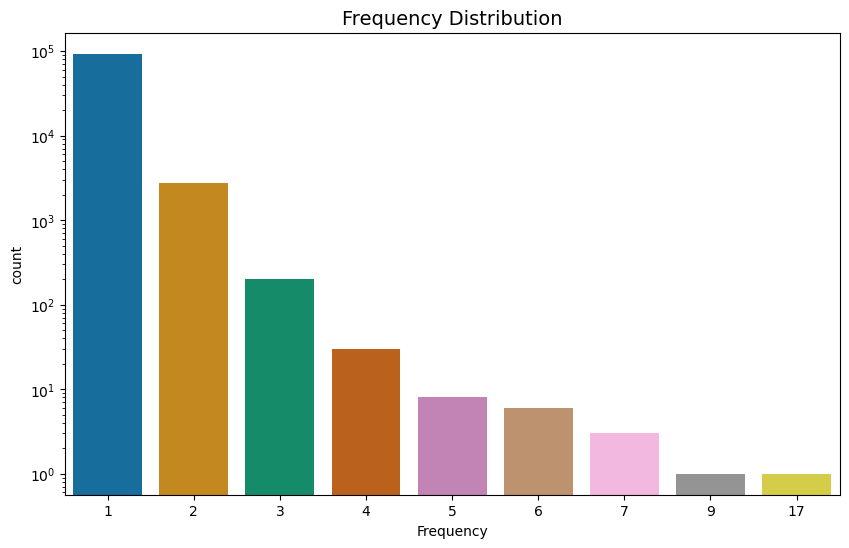

In [11]:
fig, ax = plt.subplots(1,1, figsize=(10,6))
sns.countplot(data=rfm_df, x='Frequency', ax=ax, palette='colorblind')
ax.set_yscale('log')
plt.title("Frequency Distribution", fontsize=14)
plt.show()

### Frequency (F)

To visualize the extreme skew of `Frequency`, a standard bar chart was useless. I have plotted the `value_counts()` on a **logarithmic scale** to make the drop-off visible.

* **Key Insight:** This chart is the clearest evidence of the business's core challenge. It is overwhelmingly a **"one-and-done" customer model**.
* **The "Cliff":** The y-axis shows the drop is not a gentle slope; it's a cliff. We have ~93k customers with 1 purchase, but only ~2,500 with 2 purchases. The number of repeat customers is exponentially smaller.
* **Business Impact:** This is a **retention crisis**. The business is spending a huge amount on customer acquisition (CAC) but has almost no customer lifetime value (LTV) from repeat purchases.

## Monetary

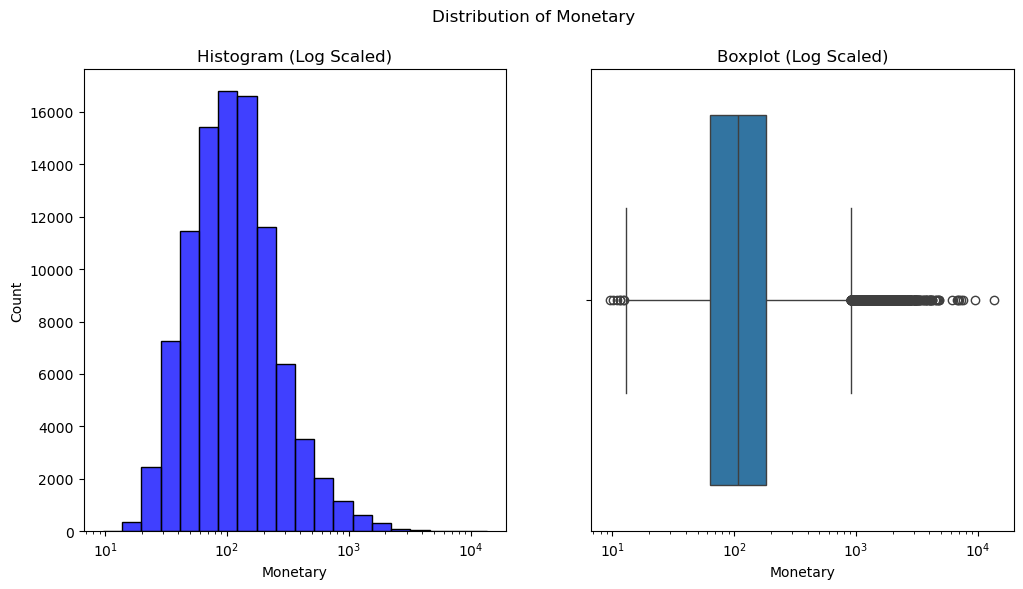

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(12,6))

# histogram
sns.histplot(data=rfm_df, x='Monetary', log_scale=True, color='blue', ax=axes[0], bins=20)
axes[0].set_title("Histogram (Log Scaled)")

# boxplot
sns.boxplot(data=rfm_df, x='Monetary', log_scale=True, ax=axes[1])
axes[1].set_title("Boxplot (Log Scaled)")
fig.suptitle("Distribution of Monetary")
plt.show()

### Monetary (M)

The `Monetary` distribution is extremely right-skewed, so I am using a **log scale** for both the histogram and boxplot to make the pattern visible.

* **Key Insight:** The plots confirm the business's "long tail." The vast majority of customers (the main "bulge" in the histogram) spend a modest amount, with the median value at **~108 BRL**.
* **Business Impact:** A very small number of "whale" customers (the outliers on the far right of the boxplot, up to 13k+ BRL) drive a disproportionately large amount of total revenue. This confirms the classic "80/20" pattern and shows the importance of identifying and retaining these few high-value customers.